# EE 559 Course Project
#### Name: Bhavya Samhitha Mallineni
#### mail id: mallinen@usc.edu
#### USCid: 6580252371

## Laptop Prediction 

#### Load all Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

#### Load all the data 

In [2]:
# Load the data into train and test sets and also separate the features from the target
train_df = pd.read_csv('laptop_data_train.csv')
test_df = pd.read_csv('laptop_data_test.csv')

X_train = train_df.drop(columns=['Number','Price'])
y_train =np.log(train_df['Price']) 
#y_train=train_df['Price']

X_test = test_df.drop(columns=['Number','Price'])
y_test = np.log(test_df['Price'])
#y_test = test_df['Price']

In [3]:
# display the feature space
X_train.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg


In [4]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           901 non-null    object 
 1   TypeName          901 non-null    object 
 2   Inches            901 non-null    float64
 3   ScreenResolution  901 non-null    object 
 4   Cpu               901 non-null    object 
 5   Ram               901 non-null    object 
 6   Memory            901 non-null    object 
 7   Gpu               901 non-null    object 
 8   OpSys             901 non-null    object 
 9   Weight            901 non-null    object 
dtypes: float64(1), object(9)
memory usage: 70.5+ KB
None


In [5]:
print("\n No. of Catergories in each feature:\n", X_train.nunique())


 No. of Catergories in each feature:
 Company              19
TypeName              6
Inches               17
ScreenResolution     37
Cpu                 100
Ram                   8
Memory               33
Gpu                  96
OpSys                 9
Weight              161
dtype: int64


#### PreProcessing  

Company 

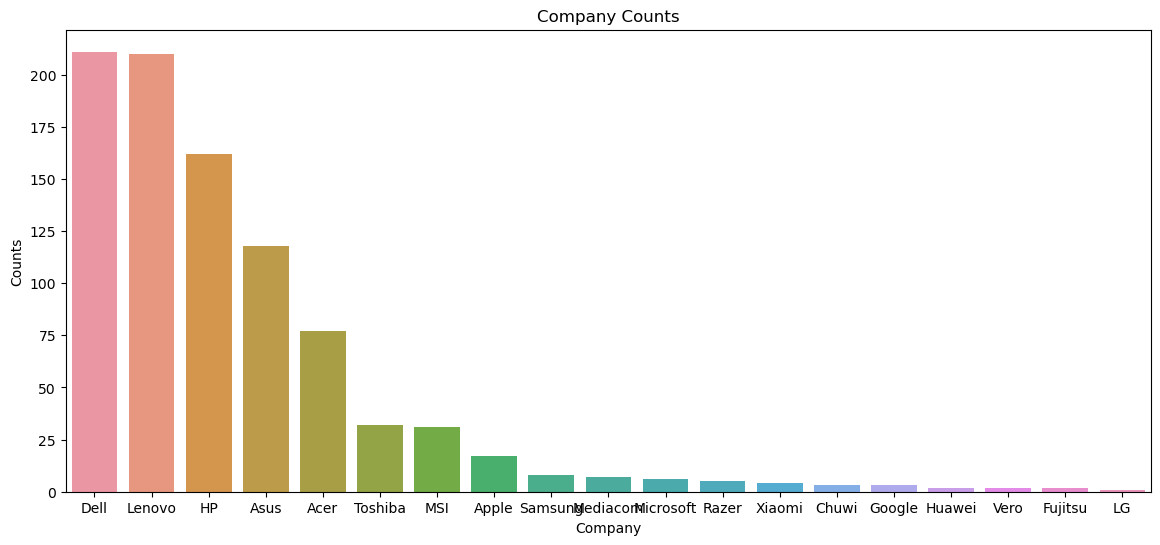

In [6]:
# Analysing Company Feature
company_counts = X_train['Company'].value_counts().reset_index()
company_counts.columns = ['Company', 'Count']
plt.figure(figsize=(14, 6))
sns.barplot(x='Company', y='Count', data=company_counts)
plt.title('Company Counts')
plt.xlabel('Company')
plt.ylabel('Counts')
plt.show()


In [7]:
# Company has 19 Unique categories inside.
# we are one hot encoding all of the categories
comp_ohencoded= pd.get_dummies(X_train['Company'])
X_train = pd.concat([X_train, comp_ohencoded], axis=1)
X_train.drop('Company', axis=1, inplace=True)
comp_ohencoded_test = pd.get_dummies(X_test['Company'])
X_test = pd.concat([X_test, comp_ohencoded_test], axis=1)
X_test.drop('Company', axis=1, inplace=True)

TypeName 

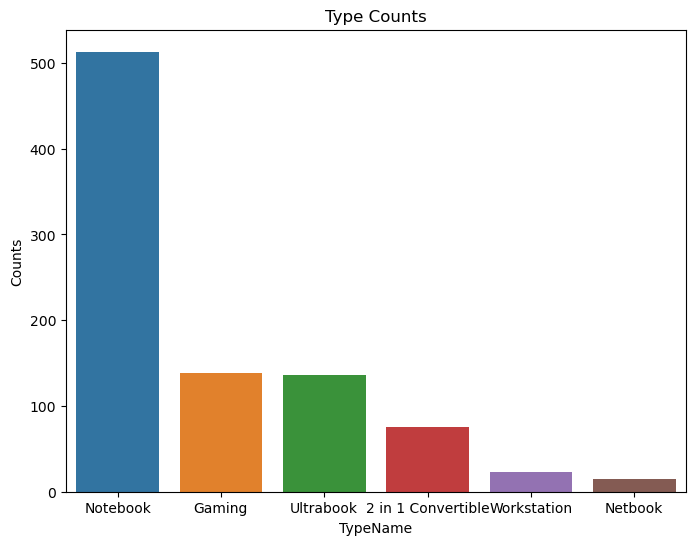

In [8]:
#Analysing the TypeName feature
type_counts = X_train['TypeName'].value_counts().reset_index()
type_counts.columns = ['TypeName', 'Count']
plt.figure(figsize=(8, 6))
sns.barplot(x='TypeName', y='Count', data=type_counts)
plt.title('Type Counts')
plt.xlabel('TypeName')
plt.ylabel('Counts')
plt.show()

In [9]:
type_ohencoded_train = pd.get_dummies(X_train['TypeName'])
X_train = pd.concat([X_train, type_ohencoded_train], axis=1)
X_train.drop('TypeName', axis=1, inplace=True)
type_ohencoded_test = pd.get_dummies(X_test['TypeName'])
X_test = pd.concat([X_test, type_ohencoded_test], axis=1)
X_test.drop('TypeName', axis=1, inplace=True)

Inches

In [10]:
# inches is float variable, so no transformation required but lets get this value range from 0 to 1
scaler = MinMaxScaler()
X_train['Inches'] = scaler.fit_transform(X_train[['Inches']])
X_test['Inches'] = scaler.transform(X_test[['Inches']])

Screen Resolution 

In [11]:
# There are 37 categories within Screen Resolution but all of them are long, so we can segregate the names and the encode them.
def break_ScreenResolution(df):
    df['ResolutionFullHD'] = df['ScreenResolution'].str.contains('Full HD').astype(int)
    df['ResolutionIPS'] = df['ScreenResolution'].str.contains('IPS').astype(int)
    df['ResolutionTouchscreen'] = df['ScreenResolution'].str.contains('Touchscreen').astype(int)
    df['ResolutionRetina'] = df['ScreenResolution'].str.contains('Retina').astype(int)
    resolution = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
    df['ScreenWidth'] = resolution[0].astype(int)
    df['ScreenHeight'] = resolution[1].astype(int)
    df.drop(columns=['ScreenResolution'], inplace=True)
    return df
X_train = break_ScreenResolution(X_train.copy())
X_test = break_ScreenResolution(X_test.copy())

In [12]:
# we can normalise screen width and height columns
X_train['ScreenWidth'] = scaler.fit_transform(X_train[['ScreenWidth']])
X_test['ScreenWidth'] = scaler.transform(X_test[['ScreenWidth']])
X_train['ScreenHeight'] = scaler.fit_transform(X_train[['ScreenHeight']])
X_test['ScreenHeight'] = scaler.transform(X_test[['ScreenHeight']])

CPU 

In [13]:
# CPU had about 100 categories so we can segregate it into Cpu_speed, and Cpu company
def break_CPU(df):
    cpu_speed = df['Cpu'].str.extract(r'(\d+\.\d+)GHz')
    cpu_speed = cpu_speed.fillna(df['Cpu'].str.extract(r'(\d+)GHz'))
    df['CpuSpeed'] = cpu_speed[0].astype(float)
    df['CpuCompany'] = df['Cpu'].str.extract(r'([A-Za-z]+)')
    return df.drop(columns=['Cpu'])
X_train = break_CPU(X_train)
X_test = break_CPU(X_test)

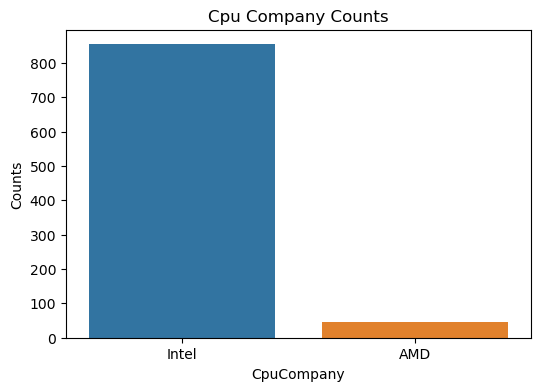

In [14]:
# after segregating the cpu analyse the company categorical column
cpu_company_counts = X_train['CpuCompany'].value_counts().reset_index()
cpu_company_counts.columns = ['CpuCompany', 'Count']
plt.figure(figsize=(6, 4))
sns.barplot(x='CpuCompany', y='Count', data=cpu_company_counts)
plt.title('Cpu Company Counts')
plt.xlabel('CpuCompany')
plt.ylabel('Counts')
plt.show()

In [15]:
# we can normalise cpu speed and hot encode cpu copany info
X_train['CpuSpeed'] = scaler.fit_transform(X_train[['CpuSpeed']])
X_test['CpuSpeed'] = scaler.transform(X_test[['CpuSpeed']])
# to one hot encode there are two categories in CPU company
cpu_ohencoded_train = pd.get_dummies(X_train['CpuCompany'])
X_train = pd.concat([X_train, cpu_ohencoded_train], axis=1)
X_train.drop('CpuCompany', axis=1, inplace=True)
cpu_ohencoded_test = pd.get_dummies(X_test['CpuCompany'])
X_test = pd.concat([X_test, cpu_ohencoded_test], axis=1)
X_test.drop('CpuCompany', axis=1, inplace=True)


Ram 

In [16]:
# For Ram we have to remove GB from the name and normalise it
X_train['Ram'] = X_train['Ram'].astype(str).str.replace('GB', '').astype(int)
X_test['Ram'] = X_test['Ram'].astype(str).str.replace('GB', '').astype(int)
X_train['Ram'] = scaler.fit_transform(X_train[['Ram']])
X_test['Ram'] = scaler.transform(X_test[['Ram']])

Memory 

In [17]:
# it has 33 diff categories and the sizes are in TB and GB these have to be al reduced to GB
def get_StorageSize(memory):
    parts = memory.split('+')
    total_storage = 0
    for part in parts:
        part = part.strip()
        size_part = ''.join(filter(str.isdigit, part.split()[0]))
        unit = part.split()[-1] 
        size = float(size_part)
        if 'TB' in unit:
            size *= 1024
        total_storage += size
    return total_storage
def get_StorageType(memory):
    types = []
    parts = memory.split('+')
    for part in parts:
        types.append(part.strip().split()[-1])
    return '+'.join(sorted(set(types))) 

X_train['Storage_inGB'] = X_train['Memory'].apply(get_StorageSize)
X_train['StorageType'] = X_train['Memory'].apply(get_StorageType)
X_train = X_train.drop(columns=['Memory'])
X_test['Storage_inGB'] = X_test['Memory'].apply(get_StorageSize)
X_test['StorageType'] = X_test['Memory'].apply(get_StorageType)
X_test = X_test.drop(columns=['Memory'])

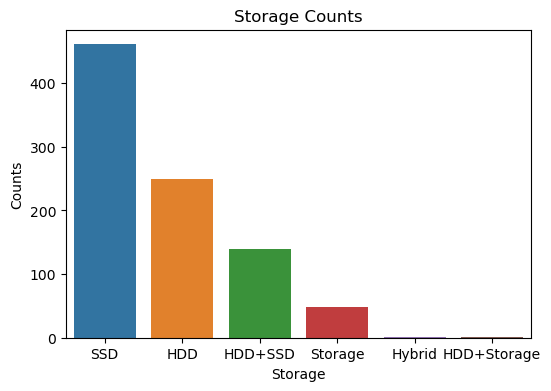

In [18]:
# after segregating the Storage analyse the company categorical column
storage_counts = X_train['StorageType'].value_counts().reset_index()
storage_counts.columns = ['StorageType', 'Count']
plt.figure(figsize=(6, 4))
sns.barplot(x='StorageType', y='Count', data=storage_counts)
plt.title('Storage Counts')
plt.xlabel('Storage')
plt.ylabel('Counts')
plt.show()

In [19]:
# normalize Total storage and hot encode storage type
X_train['Storage_inGB'] = scaler.fit_transform(X_train[['Storage_inGB']])
X_test['Storage_inGB'] = scaler.transform(X_test[['Storage_inGB']])


storage_encoded_train = pd.get_dummies(X_train['StorageType'])
X_train = pd.concat([X_train, storage_encoded_train], axis=1)
X_train.drop('StorageType', axis=1, inplace=True)
storage_encoded_test = pd.get_dummies(X_test['StorageType'])
X_test = pd.concat([X_test, storage_encoded_test], axis=1)
X_test.drop('StorageType', axis=1, inplace=True)

GPU 

In [20]:
def get_RareLabels(df, column, threshold=0.05):
    counts = df[column].value_counts(normalize=True)
    rare_labels = counts[counts < threshold].index
    df[column] = df[column].apply(lambda x: 'Miscellaneous' if x in rare_labels else x)
    return df
threshold = 0.05
X_train = get_RareLabels(X_train.copy(), 'Gpu', threshold)
X_test = get_RareLabels(X_test.copy(), 'Gpu', threshold)

In [21]:
# after rare coding on hot encode them 
gpu_encoded_train = pd.get_dummies(X_train['Gpu'])
X_train = pd.concat([X_train, gpu_encoded_train], axis=1)
X_train.drop('Gpu', axis=1, inplace=True)
gpu_encoded_test = pd.get_dummies(X_test['Gpu'])
X_test = pd.concat([X_test, gpu_encoded_test], axis=1)
X_test.drop('Gpu', axis=1, inplace=True)


OpSys 

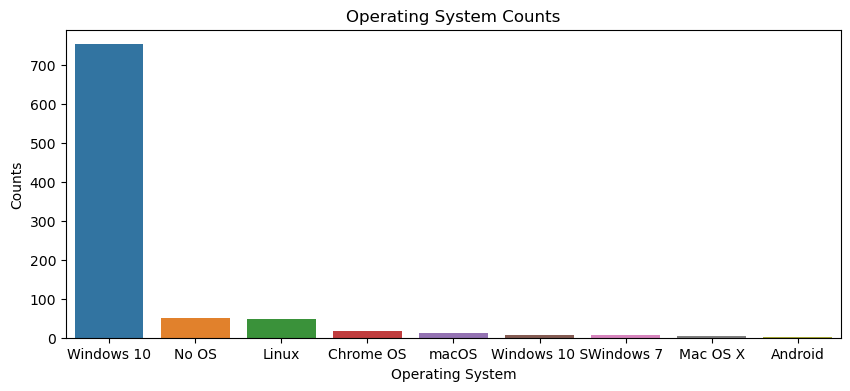

In [22]:
op_sys_counts = X_train['OpSys'].value_counts().reset_index()
op_sys_counts.columns = ['OpSys', 'Count']
plt.figure(figsize=(10, 4))
sns.barplot(x='OpSys', y='Count', data=op_sys_counts)
plt.title('Operating System Counts')
plt.xlabel('Operating System')
plt.ylabel('Counts')
plt.show()

In [23]:
#one hot encode the operating systems
opsys_encoded_train = pd.get_dummies(X_train['OpSys'])
X_train = pd.concat([X_train, opsys_encoded_train], axis=1)
X_train.drop('OpSys', axis=1, inplace=True)
opsys_encoded_test = pd.get_dummies(X_test['OpSys'])
X_test = pd.concat([X_test, opsys_encoded_test], axis=1)
X_test.drop('OpSys', axis=1, inplace=True)

Weight 

In [24]:
X_train['Weight'] = X_train['Weight'].astype(str).str.replace('kg', '').astype(float)
X_test['Weight'] = X_test['Weight'].astype(str).str.replace('kg', '').astype(float)

X_train['Weight'] = scaler.fit_transform(X_train[['Weight']])
X_test['Weight'] = scaler.transform(X_test[['Weight']])

#### Feature Dimenionality Adjustment

In [25]:
# Match the columns between train and test data 
def delete_duplicates(df):
    return df.loc[:, ~df.columns.duplicated()]

missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
extra_cols = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns=extra_cols)
X_test = X_test[X_train.columns]
X_train = X_train.sort_index(axis=1)
X_test = X_test.sort_index(axis=1)
X_train = delete_duplicates(X_train)
X_test = delete_duplicates(X_test)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   2 in 1 Convertible       901 non-null    uint8  
 1   AMD                      901 non-null    uint8  
 2   Acer                     901 non-null    uint8  
 3   Android                  901 non-null    uint8  
 4   Apple                    901 non-null    uint8  
 5   Asus                     901 non-null    uint8  
 6   Chrome OS                901 non-null    uint8  
 7   Chuwi                    901 non-null    uint8  
 8   CpuSpeed                 901 non-null    float64
 9   Dell                     901 non-null    uint8  
 10  Fujitsu                  901 non-null    uint8  
 11  Gaming                   901 non-null    uint8  
 12  Google                   901 non-null    uint8  
 13  HDD                      901 non-null    uint8  
 14  HDD+SSD                  9

In [27]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   2 in 1 Convertible       402 non-null    uint8  
 1   AMD                      402 non-null    uint8  
 2   Acer                     402 non-null    uint8  
 3   Android                  402 non-null    uint8  
 4   Apple                    402 non-null    uint8  
 5   Asus                     402 non-null    uint8  
 6   Chrome OS                402 non-null    uint8  
 7   Chuwi                    402 non-null    int64  
 8   CpuSpeed                 402 non-null    float64
 9   Dell                     402 non-null    uint8  
 10  Fujitsu                  402 non-null    uint8  
 11  Gaming                   402 non-null    uint8  
 12  Google                   402 non-null    int64  
 13  HDD                      402 non-null    uint8  
 14  HDD+SSD                  4

#### Feature Dimensionality Reduction 

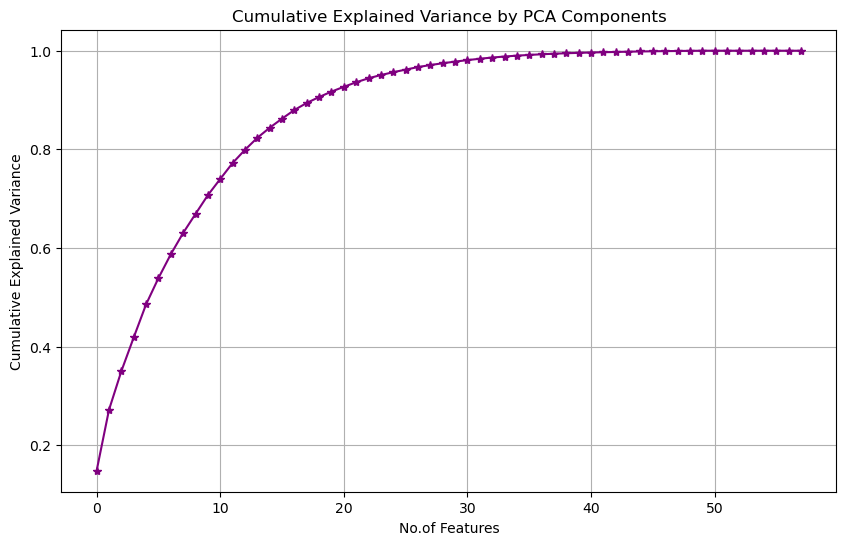

In [28]:
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance,color='purple', marker='*')
plt.xlabel('No.of Features')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [29]:
np.where(cumulative_explained_variance >= 0.95)[0][0]

23

In [30]:
pca_37 = PCA(n_components= 37)
X_train_pca = pca_37.fit_transform(X_train)
X_test_pca = pca_37.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((901, 37), (402, 37))

### Training  

##### Trivial System

In [31]:
mean_price = np.mean(y_train)
y_pred_trivial = np.full(shape=y_test.shape, fill_value=mean_price)

rmse_trivial = np.sqrt(mean_squared_error(y_test, y_pred_trivial))
mae_trivial = mean_absolute_error(y_test, y_pred_trivial)
r2_trivial = r2_score(y_test, y_pred_trivial)

print(f'Root Mean Squared Error for Trivial System: {rmse_trivial:.2f}')
print(f'Mean Absolute Error for Trivial System: {mae_trivial:.2f}')
print(f'R² Score for Trivial System: {r2_trivial:.2f}')

Root Mean Squared Error for Trivial System: 0.63
Mean Absolute Error for Trivial System: 0.52
R² Score for Trivial System: -0.01


##### Baseline

In [37]:
#Linear Regression
model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

rmse_baseline_lr = mean_squared_error(y_test, y_pred, squared=False)
mae_baseline_lr = mean_absolute_error(y_test, y_pred)
r2_baseline_lr = r2_score(y_test, y_pred)

print("RMSE:", rmse_baseline_lr)
print("MAE:",mae_baseline_lr)
print("R2 Score:", r2_baseline_lr)


RMSE: 0.2997051178649677
MAE: 0.2306426811078932
R2 Score: 0.7720855380001098


In [38]:
#1NN
model=MLPRegressor()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

rmse_baseline_nn = mean_squared_error(y_test, y_pred, squared=False)
mae_baseline_nn = mean_absolute_error(y_test, y_pred)
r2_baseline_nn = r2_score(y_test, y_pred)

print("RMSE:", rmse_baseline_nn)
print("MAE:",mae_baseline_nn)
print("R2 Score:", r2_baseline_nn)

RMSE: 0.391580166410931
MAE: 0.3024634412621241
R2 Score: 0.610932514210329


C:\Users\india\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Linear Regression

Linear Regression with Pseudoinverse Solution

In [34]:
def get_weight(X, y):
    X_with_intercept = np.c_[np.ones(X.shape[0]), X]
    weight = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y)
    return weight

def predict(X, w):
    X_aug = np.c_[np.ones(X.shape[0]), X]
    y_pred = X_aug.dot(w) 
    return y_pred

def get_mse(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2
    mse = np.mean(squared_errors)    
    return mse


num_folds = 5
kf = KFold(n_splits=num_folds)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_train_pca):
    X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]    
    weights = get_weight(X_train_fold, y_train_fold)
    y_pred_fold = predict(X_val_fold, weights)
    rmse_fold = np.sqrt(get_mse(y_val_fold, y_pred_fold))
    mae_fold = np.mean(np.abs(y_val_fold - y_pred_fold))
    y_mean_fold = np.mean(y_val_fold)
    ss_total_fold = np.sum((y_val_fold - y_mean_fold) ** 2)
    ss_residual_fold = np.sum((y_val_fold - y_pred_fold) ** 2)
    r2_fold = 1 - (ss_residual_fold / ss_total_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)
    r2_scores.append(r2_fold)


mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)

print(f'Mean RMSE for linear regression Validation set : {mean_rmse:.2f} ± {std_rmse:.2f}')
print(f'Mean MAE for linear regression Validation set: {mean_mae:.2f}')
print(f'Mean R² Score for linear regression Validation set: {mean_r2:.2f}')



Mean RMSE for linear regression Validation set : 0.26 ± 0.02
Mean MAE for linear regression Validation set: 0.21
Mean R² Score for linear regression Validation set: 0.81


In [35]:
y_pred_linear = predict(X_test_pca, get_weight(X_train_pca, y_train))
rmse_linear = np.sqrt(get_mse(y_test, y_pred_linear))
mae_linear = np.mean(np.abs(y_test - y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

print(f'RMSE for linear regression Test set: {rmse_linear:.2f}')
print(f'MAE for linear regression Test set: {mae_linear:.2f}')
print(f'R² Score for linear regression Test set: {r2_linear:.2f}')

RMSE for linear regression Test set: 0.30
MAE for linear regression Test set: 0.23
R² Score for linear regression Test set: 0.77


Linear Regression with Grediant Descent MSE Algorithm

In [ ]:
lr = 0.01
epochs = 1000
n = float(len(X_train_pca))

w = np.zeros(X_train_pca.shape[1])
b = 0
for i in range(epochs):
    y_pred = np.dot(X_train_pca, w) + b
    error = y_train - y_pred
    dw = (-2/n) * np.dot(X_train_pca.T, error)
    db = (-2/n) * np.sum(error)
    w = w - lr * dw
    b = b - lr * db

    if i % 100 == 0:
        cost = (1/n) * np.sum(error**2)


def predict(X):
    return np.dot(X, w) + b

y_test_pred = predict(X_test_pca)
test_cost = (1/len(X_test_pca)) * np.sum((y_test - y_test_pred)**2)

rmse_linear_gd = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_linear_gd = mean_absolute_error(y_test, y_test_pred)
r2_linear_gd = r2_score(y_test, y_test_pred)

print(f'RMSE for GD linear regression Test set: {rmse_linear_gd:.2f}')
print(f'MAE for GD linear regression Test set: {mae_linear_gd:.2f}')
print(f'R² Score for GD linear regression Test set: {r2_linear_gd:.2f}')


### Support Vector Regressor

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds)

rmse_scores = []
mae_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_train_pca):
    X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[test_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]  
    model_svr = SVR(kernel ='rbf',C = 10 ,gamma = 0.1)
    model_svr.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_svr.predict(X_val_fold)  
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)  
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)
    r2_scores.append(r2_fold)

mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)

print(f'Mean RMSE for SVR: {mean_rmse:.2f} ± {std_rmse:.2f}')
print(f'Mean MAE for SVR: {mean_mae:.2f}')
print(f'Mean R² Score for SVR: {mean_r2:.2f}')

In [ ]:
model_svr.fit(X_train_pca, y_train)

y_pred_svr = model_svr.predict(X_test_pca)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'RMSE for SVR: {rmse_svr:.2f}')
print(f'MAE for SVR: {mae_svr:.2f}')
print(f'R-squared for SVR: {r2_svr:.2f}')

### 1 Neaural Network

In [ ]:
num_folds_nn = 5
kf_nn = KFold(n_splits=num_folds_nn)
rmse_scores_nn = []
mae_scores_nn = []
r2_scores_nn = []

for train_index_nn, test_index_nn in kf_nn.split(X_train_pca):
    X_train_fold_nn, X_val_fold_nn = X_train_pca[train_index_nn], X_train_pca[test_index_nn]
    y_train_fold_nn, y_val_fold_nn = y_train[train_index_nn], y_train[test_index_nn]

    model_nn = MLPRegressor(
        hidden_layer_sizes=(1000,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.01,
        power_t=0.5,
        max_iter=1000,
        shuffle=True,
        random_state=1,
        tol=1e-4,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )

    model_nn.fit(X_train_fold_nn, y_train_fold_nn)
    y_pred_fold_nn = model_nn.predict(X_val_fold_nn)
    rmse_fold_nn = np.sqrt(mean_squared_error(y_val_fold_nn, y_pred_fold_nn))
    mae_fold_nn = mean_absolute_error(y_val_fold_nn, y_pred_fold_nn)
    r2_fold_nn = r2_score(y_val_fold_nn, y_pred_fold_nn)
    rmse_scores_nn.append(rmse_fold_nn)
    mae_scores_nn.append(mae_fold_nn)
    r2_scores_nn.append(r2_fold_nn)
mean_rmse_nn = np.mean(rmse_scores_nn)
std_rmse_nn = np.std(rmse_scores_nn)
mean_mae_nn = np.mean(mae_scores_nn)
mean_r2_nn = np.mean(r2_scores_nn)

print(f'Mean RMSE for Neural Network for Validation Set: {mean_rmse_nn:.2f} ± {std_rmse_nn:.2f}')
print(f'Mean MAE for Neural Network for Validation Set: {mean_mae_nn:.2f}')
print(f'Mean R² Score for Neural Network for Validation Set: {mean_r2_nn:.2f}')

In [ ]:
model_nn.fit(X_train_pca, y_train)

y_pred_nn = model_nn.predict(X_test_pca)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'RMSE for Neural Network Test Set: {rmse_nn:.2f}')
print(f'MAE for Neural Network Test Set: {mae_nn:.2f}')
print(f'R-squared for Neural Network Test Set: {r2_nn:.2f}')

In [ ]:
models = ['Linear Regression', 'SVR', 'Neural Network']

rmse_values = [rmse_linear, rmse_svr, rmse_nn]
mae_values = [mae_linear, mae_svr, mae_nn]
r2_values = [r2_linear, r2_svr, r2_nn]

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(models, rmse_values, color=['red', 'purple', 'blue'])
plt.title('RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')


plt.subplot(1, 3, 2)
plt.bar(models, mae_values, color=['red', 'purple', 'blue'])
plt.title('MAE Comparison')
plt.xlabel('Models')
plt.ylabel('MAE')

plt.subplot(1, 3, 3)
plt.bar(models, r2_values, color=['red', 'purple', 'blue'])
plt.title('R-squared Comparison')
plt.xlabel('Models')
plt.ylabel('R-squared')

plt.tight_layout()
plt.show()
